# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con etiquetado para construir un modelo que clasifique las reseñas como positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Instrucciones del proyecto

1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
8. Muestra tus hallazgos.

¡Importante! Para tu comodidad, la plantilla del proyecto ya contiene algunos fragmentos de código, así que puedes usarlos si lo deseas. Si deseas hacer borrón y cuenta nueva, simplemente elimina todos esos fragmentos de código. Aquí está la lista de fragmentos de código:

- un poco de análisis exploratorio de datos con algunos gráficos;
- evaluate_model(): una rutina para evaluar un modelo de clasificación que se ajusta a la interfaz de predicción de scikit-learn;
- BERT_text_to_embeddings(): una ruta para convertir lista de textos en insertados con BERT.

Tu trabajo principal es construir y evaluar modelos.

Como puedes ver en la plantilla del proyecto, te sugerimos probar modelos de clasificación basados en regresión logística y potenciación del gradiente, pero puedes probar otros métodos. Puedes jugar con la estructura de la plantilla del proyecto siempre y cuando sigas sus instrucciones.

No tienes que usar BERT para el proyecto porque requiere mucha potencia computacional y será muy lento en la CPU para el conjunto de datos completo. Debido a esto, BERT generalmente debe ejecutarse en GPU para tener un rendimiento adecuado. Sin embargo, puedes intentar incluir BERT en el proyecto para una parte del conjunto de datos. Si deseas hacer esto, te sugerimos hacerlo de manera local y solo tomar un par de cientos de objetos por cada parte del conjunto de datos (entrenamiento/prueba) para evitar esperar demasiado tiempo. Asegúrate de indicar que estás usando BERT en la primera celda (el encabezado de tu proyecto).

## Descripción de los datos
Los datos se almacenan en el archivo imdb_reviews.tsv. Descargar el conjunto de datos.

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

Aquí se describen los campos seleccionados:

- review: el texto de la reseña
- pos: el objetivo, '0' para negativo y '1' para positivo
- ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente
Hay otros campos en el conjunto de datos, puedes explorarlos si lo deseas.

# Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import sklearn.metrics as metrics
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.model_selection import train_test_split
import logging
import math
import transformers
from tqdm.auto import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

c:\Users\Santiago\Documents\Data science\Proyectos\proyecto_14\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargamos los datos

In [2]:
data=pd.read_csv('files/datasets/imdb_reviews.tsv',sep='\t')

In [3]:
data.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240.0,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240.0,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240.0,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [5]:
data.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


# Preprocesamiento

In [6]:
#Revisamos los ausentes
data.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
#Revisamos los duplicados
data.duplicated().sum()

0

In [8]:
columns=['end_year','runtime_minutes','genres']
for col in columns:
  print(data[col].value_counts())

end_year
\N      45052
2007      225
2008      190
2006      140
2009      130
2010      124
2003      102
2002       97
2005       96
1996       96
2004       84
2001       75
1995       69
1999       61
1983       55
1989       49
2012       47
1985       40
2000       40
1976       37
1987       35
1994       34
1986       33
2017       32
1998       27
1990       26
2011       22
1982       21
2013       19
1975       17
2014       17
1984       16
1997       16
1981       16
1960       16
1973       15
1979       15
1991       14
1988       14
1993       13
1977       10
1978        9
1974        7
1965        7
1972        7
1970        7
2020        6
1961        6
1969        6
1980        5
2016        5
1957        5
1955        4
2018        4
1966        4
2019        4
1962        3
1968        2
1953        2
1959        1
Name: count, dtype: int64
runtime_minutes
90     2442
95     1820
100    1420
92     1418
93     1311
       ... 
222       1
33        1
215       1
2

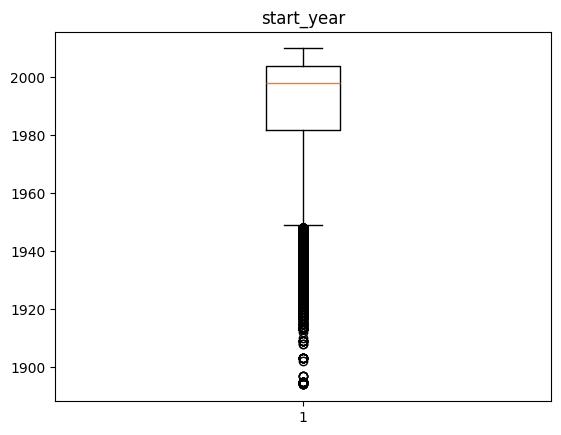

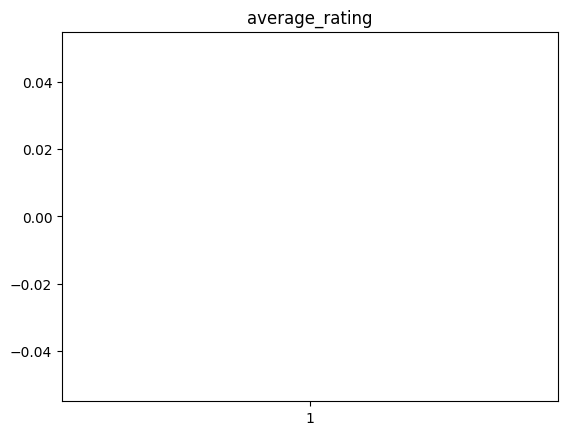

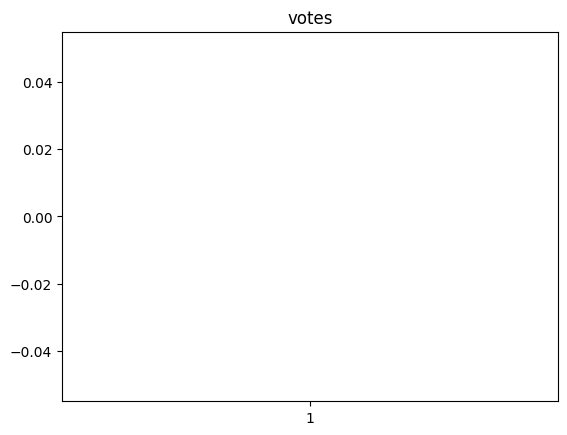

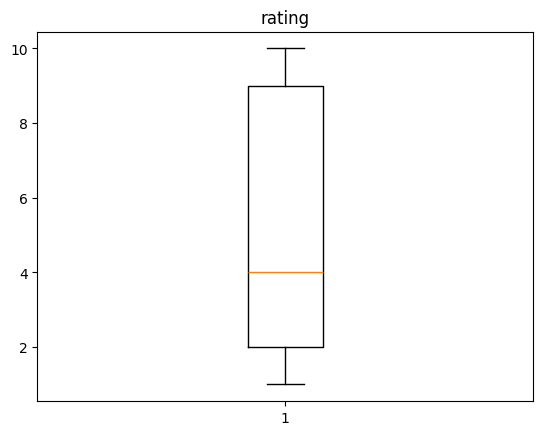

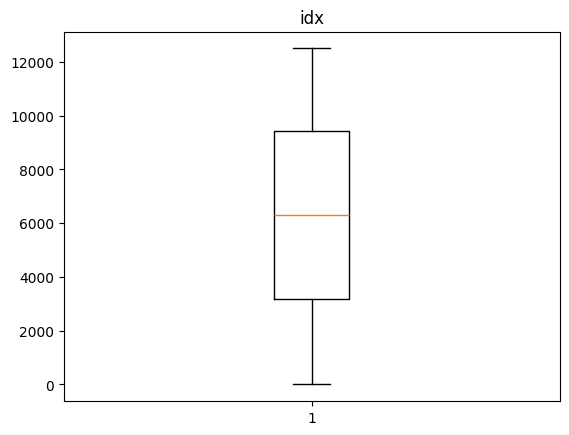

In [9]:
numeric=['start_year','average_rating','votes','rating','idx']
for column in numeric:
    plt.boxplot(data[column])
    plt.title(column)   
    plt.show()

In [10]:
data[data=='\\N'].count()

tconst                 0
title_type             0
primary_title          0
original_title         0
start_year             0
end_year           45052
runtime_minutes      488
is_adult               0
genres                26
average_rating         0
votes                  0
review                 0
rating                 0
sp                     0
pos                    0
ds_part                0
idx                    0
dtype: int64

In [11]:
data[data=='\\N'].count()/data.shape[0]

tconst             0.000000
title_type         0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
end_year           0.951850
runtime_minutes    0.010310
is_adult           0.000000
genres             0.000549
average_rating     0.000000
votes              0.000000
review             0.000000
rating             0.000000
sp                 0.000000
pos                0.000000
ds_part            0.000000
idx                0.000000
dtype: float64

Podemos ver que hay varias columnas que tienen el caracter de salto de línea '\\n', por lo cual debemos imputarlo o eliminarlo en los casos en los cuales el dato es menor al 2%, para el caso de la columna 'end_year' al tener el 95% de los datos con este valor, dejamos los datos así para no corromper la data.

In [12]:
columns=['runtime_minutes','genres']
for col in columns:
  data[col].replace('\\N',np.nan,inplace=True)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\2506741737.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].replace('\\N',np.nan,inplace=True)


In [13]:
data.isna().sum()

tconst               0
title_type           0
primary_title        0
original_title       0
start_year           0
end_year             0
runtime_minutes    488
is_adult             0
genres              26
average_rating       2
votes                2
review               0
rating               0
sp                   0
pos                  0
ds_part              0
idx                  0
dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  46843 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47305 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [15]:
data['runtime_minutes']=pd.to_numeric(data['runtime_minutes'])

In [16]:
nancols=['runtime_minutes','average_rating','votes']
for column in nancols:
  data[column].fillna(data[column].mean(),inplace=True)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\3613174535.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(),inplace=True)


In [17]:
data['genres'].fillna(data['genres'].mode()[0],inplace=True)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\3932385473.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['genres'].fillna(data['genres'].mode()[0],inplace=True)


In [18]:
data.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Imputamos todos los valores ausentes y sustituimos el valor \\N

# Análisis

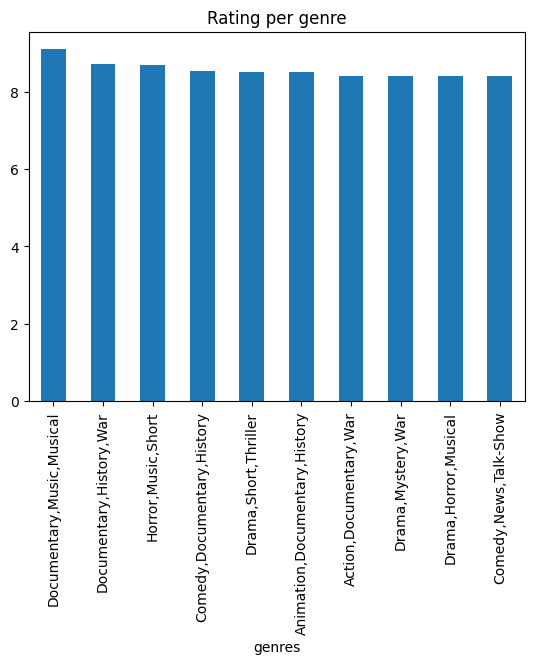

In [19]:
data_rating=data.groupby('genres')['average_rating'].mean().sort_values(ascending=False).head(10)
data_rating.plot(kind='bar',title='Rating per genre')
plt.show()

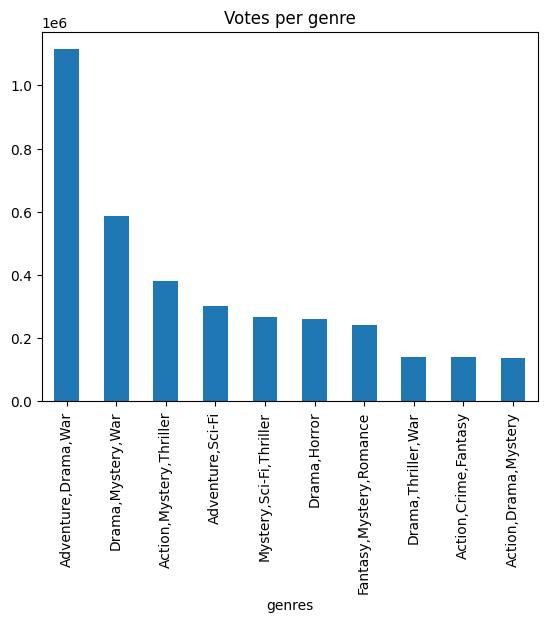

In [20]:
data_voting=data.groupby('genres')['votes'].mean().sort_values(ascending=False).head(10)
data_voting.plot(kind='bar',title='Votes per genre')
plt.show()

Podemos ver que los generos que mejor calificación tienen son 'Documentales, musica, musical', seguido de 'Documentales, historia, guerra' y 'Horror, musica, corto'. Por otro lado, los generos que tienen más votos son 'Aventura, Drama, Guerra', 'Drama, misterio, guerra' y 'Acción, misterio, terror'.

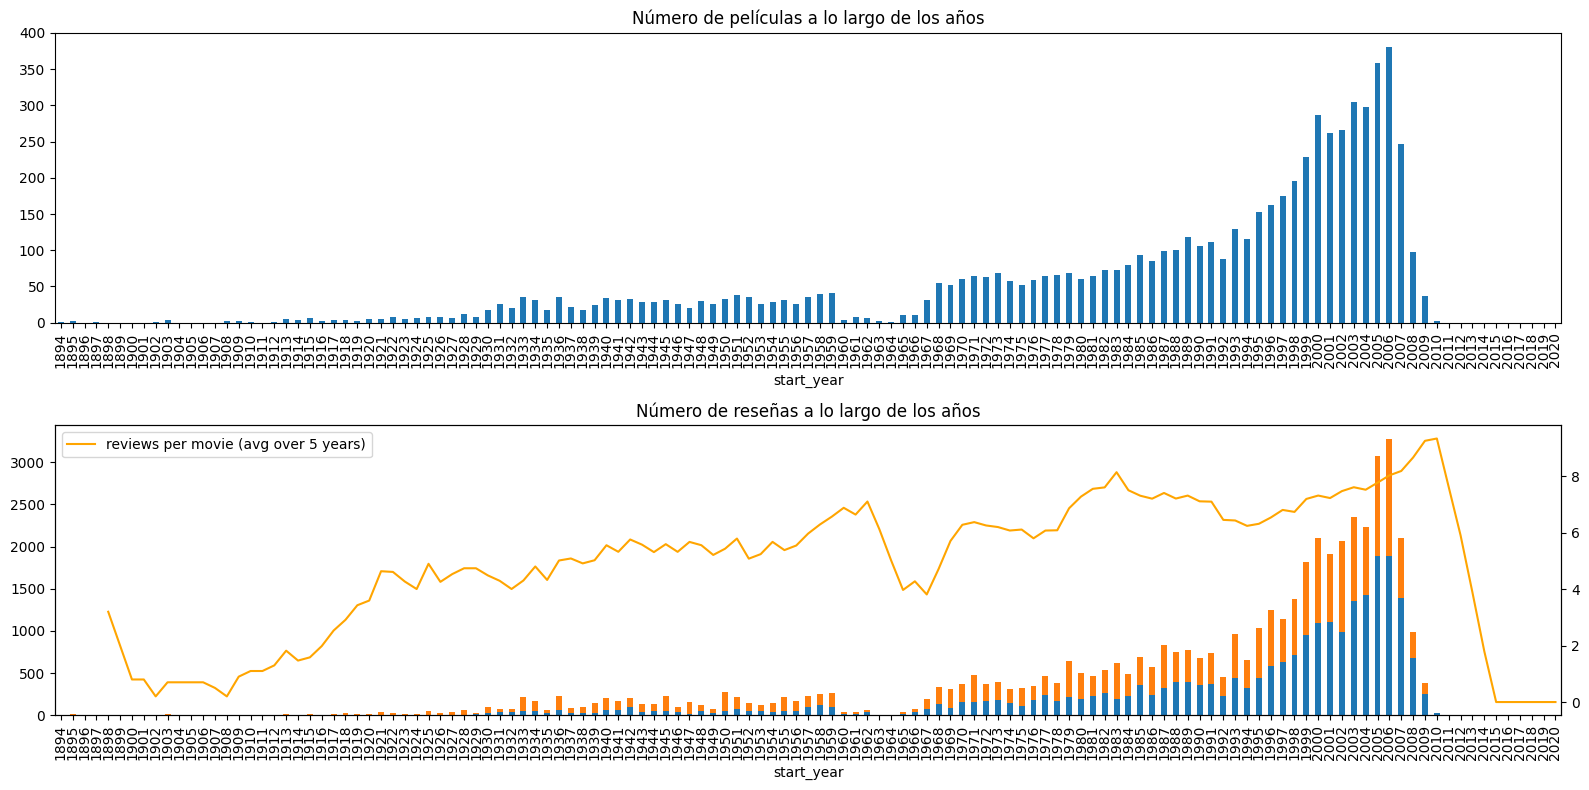

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = data[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = data.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = data['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

  Podemos evidenciar que el número de peliculas aumenta al pasar de los años al igual que el número de reseñas y la media de las reseñas cada 5 años.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

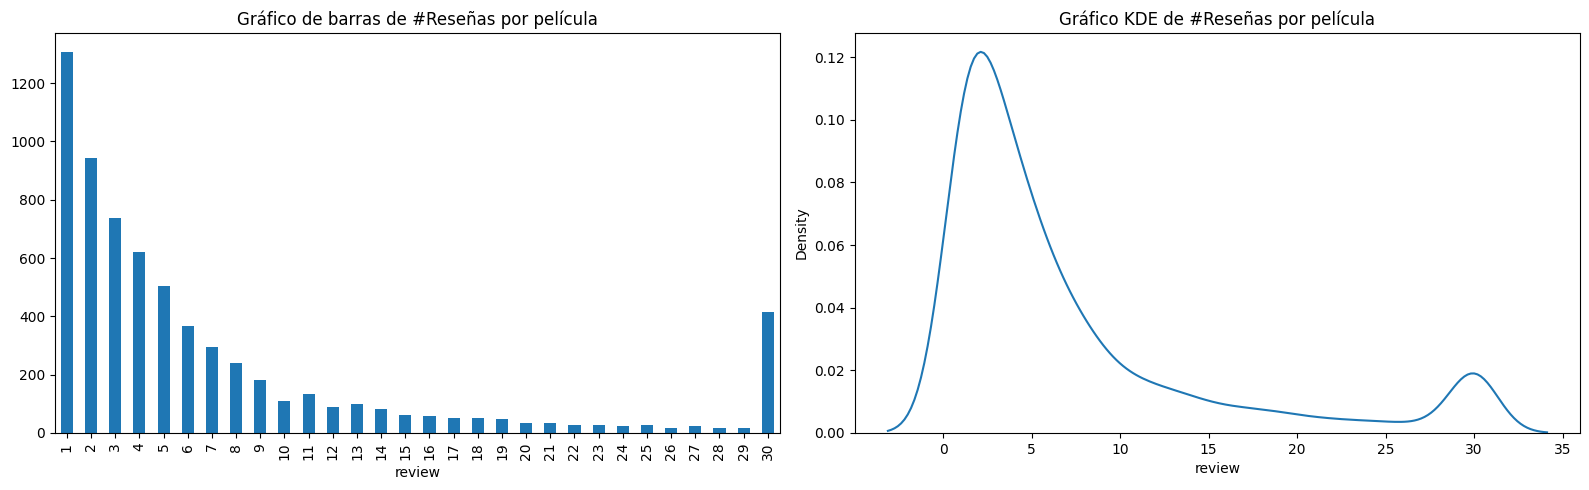

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = data.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = data.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [23]:
data['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

<Axes: xlabel='pos'>

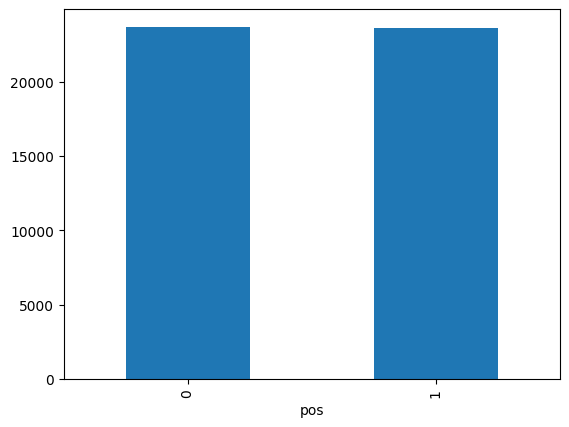

In [24]:
data['pos'].value_counts().plot(kind='bar')

Al ver las clases de los datos, podemos ver que están balanceadas, por lo cual no es necesario aplicar técnicas de balanceo.

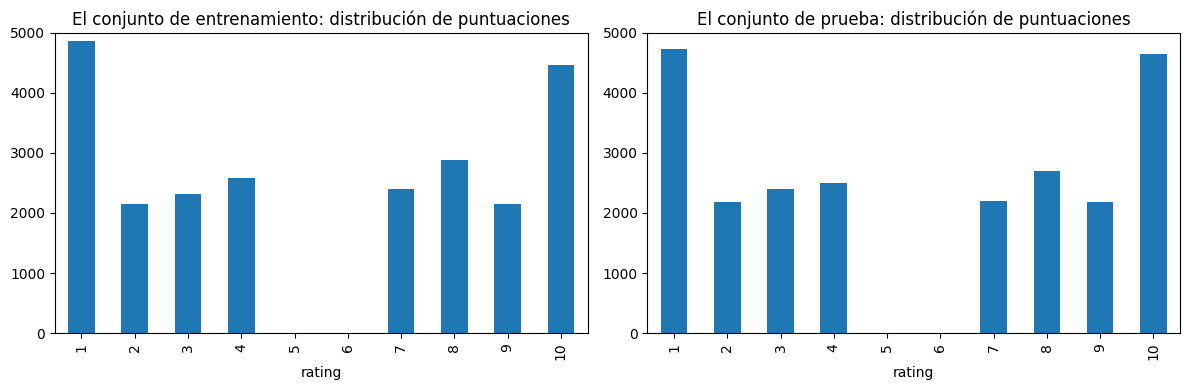

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft =data.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = data.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Podemos ver que las calificaciones de los datos en el dataset de entrenamiento y prueba son relativamente parecidos.

C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\1775897824.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\1775897824.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\1775897824.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_17100\1775897824.py:31: UserWarning: 

S

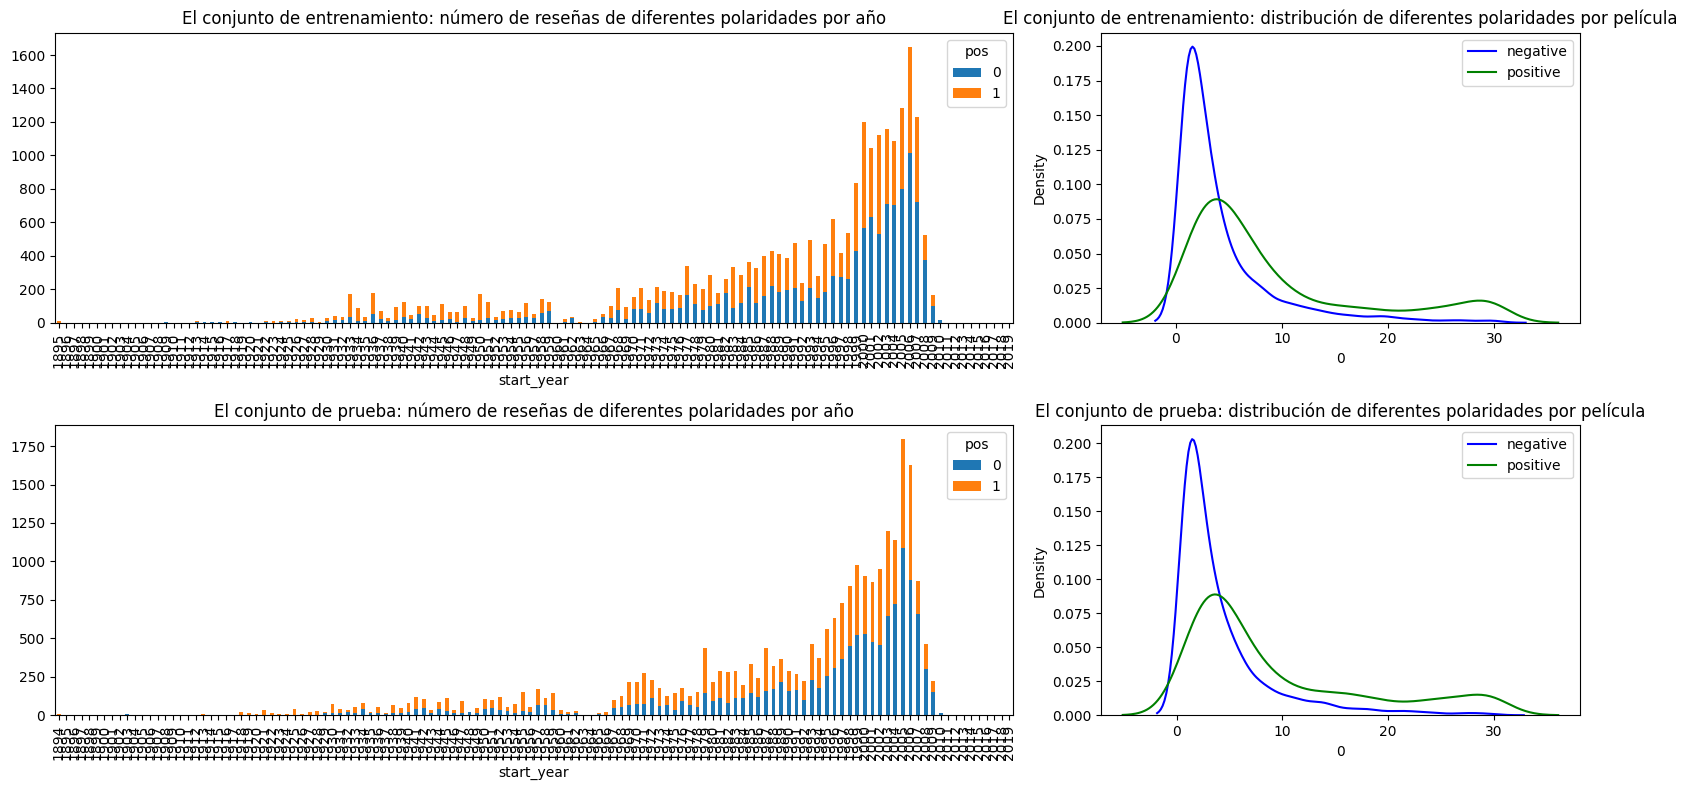

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = data.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = data.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = data.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = data.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Al hacer el análisis del número de reseñas, y el número de peliculas segmentando por los datos de entrenamiento y datos de prueba, podemos ver que ambos conjuntos de datos se comportan de manera creciente al pasar del tiempo.

# Normalización

In [27]:
def clear_text(text):
    pattern=r"[^a-zA-Z']"
    text=re.sub(pattern," ",text)
    text=text.split()
    text=" ".join(text)
    text=text.lower()
    return text

In [28]:
data['review_norm']=data['review'].apply(clear_text)
#data['review_norm']=data['review_norm'].str.lower()

Limpiamos los datos para que todo sea letras en minusculas.

# Preprocesamiento del modelamiento

In [29]:
#Separamos los datos de entrenamiento
data_train=data[data['ds_part']=='train']
data_test=data[data['ds_part']=='test']
features_train=data_train['review_norm']
features_test=data_test['review_norm']
target_train=data_train['pos']
target_test=data_test['pos']

In [30]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

# Entrenamiento

## Modelo 0 - Dummie Classifier

In [31]:
def nltk_tokenizer(data):
  lemmatizer=WordNetLemmatizer()
  tokens=word_tokenize(data)
  lemmas=[lemmatizer.lemmatize(token) for token in tokens]
  return ' '.join(lemmas)

In [32]:
features_train=features_train.apply(nltk_tokenizer)
features_test=features_test.apply(nltk_tokenizer)

KeyboardInterrupt: 

### TF-IDF

In [ ]:
stop_words = list(nltk_stopwords.words('english'))
count_vect=TfidfVectorizer(stop_words=stop_words)
features_train = count_vect.fit_transform(features_train)
features_test = count_vect.transform(features_test)
print('El tamaño de la matriz TF-IDF:', features_train.shape)

El tamaño de la matriz TF-IDF: (23796, 64299)


          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


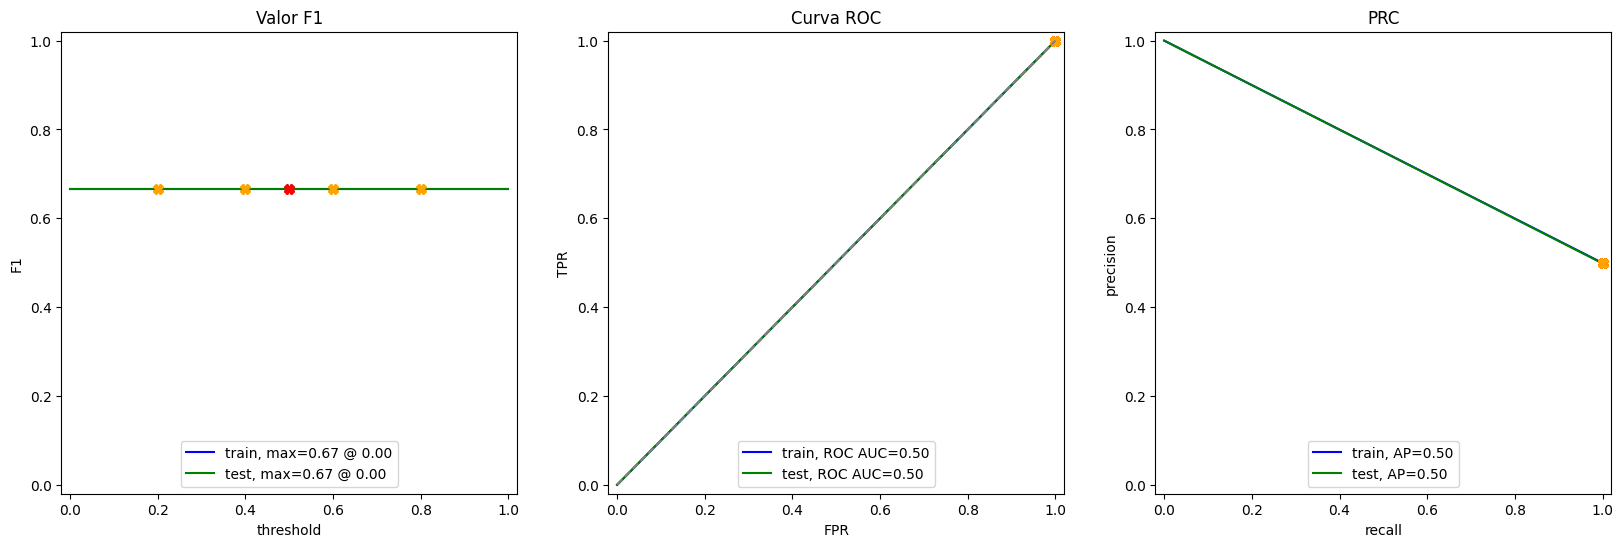

In [ ]:
dummy_clf = DummyClassifier(strategy="constant",constant=1)
dummy_clf.fit(features_train,target_train)
evaluate_model(dummy_clf, features_train, target_train, features_test, target_test)

## Modelo 1 - NLTK, TF-IDF y CatBoost

### Catboost

Learning rate set to 0.5
0:	learn: 0.6005186	total: 792ms	remaining: 32.5s
1:	learn: 0.5567318	total: 1.36s	remaining: 27.3s
2:	learn: 0.5290161	total: 1.99s	remaining: 25.9s
3:	learn: 0.5103118	total: 2.58s	remaining: 24.5s
4:	learn: 0.4936670	total: 3.15s	remaining: 23.3s
5:	learn: 0.4804473	total: 3.76s	remaining: 22.6s
6:	learn: 0.4683514	total: 4.32s	remaining: 21.6s
7:	learn: 0.4561248	total: 4.91s	remaining: 20.8s
8:	learn: 0.4460717	total: 5.47s	remaining: 20.1s
9:	learn: 0.4367600	total: 6.03s	remaining: 19.3s
10:	learn: 0.4270225	total: 6.58s	remaining: 18.6s
11:	learn: 0.4202925	total: 7.15s	remaining: 17.9s
12:	learn: 0.4141472	total: 7.8s	remaining: 17.4s
13:	learn: 0.4086592	total: 8.44s	remaining: 16.9s
14:	learn: 0.4024594	total: 9.03s	remaining: 16.2s
15:	learn: 0.3977950	total: 9.58s	remaining: 15.6s
16:	learn: 0.3932914	total: 10.1s	remaining: 14.9s
17:	learn: 0.3890929	total: 10.7s	remaining: 14.3s
18:	learn: 0.3850762	total: 11.3s	remaining: 13.7s
19:	learn: 0.3805

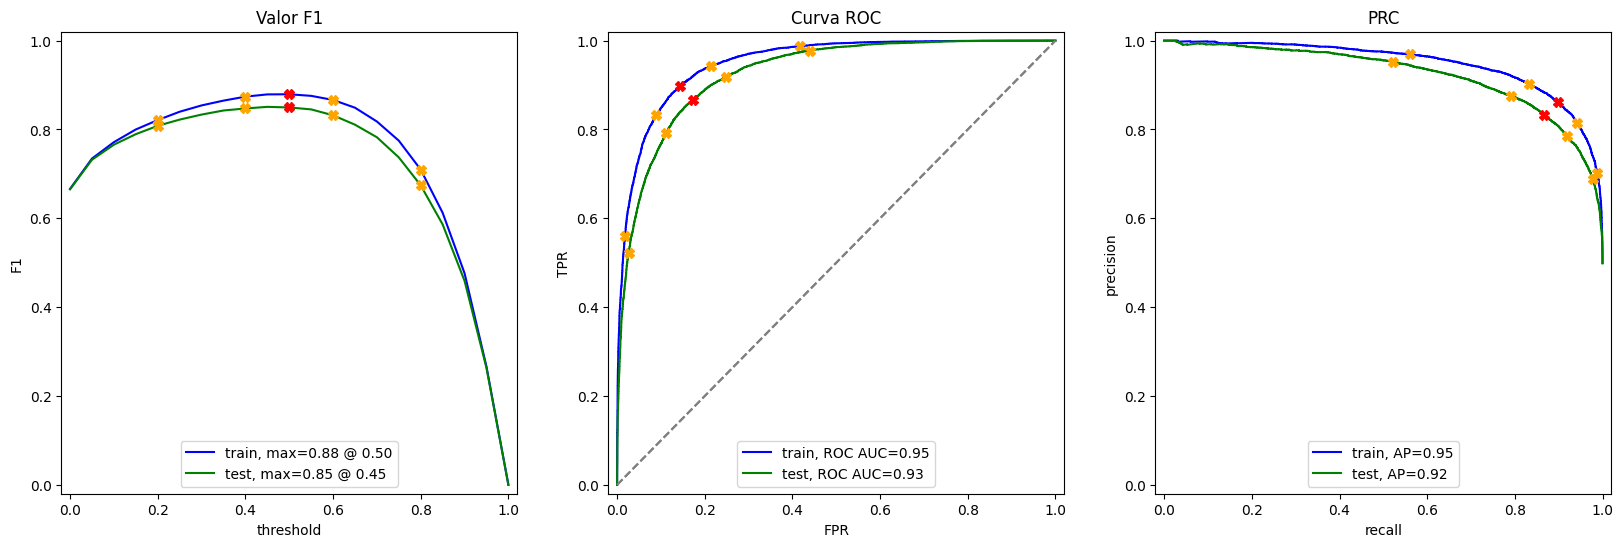

In [ ]:
seed=42
model_cat=CatBoostClassifier(seed)
model_cat.fit(features_train,target_train)
evaluate_model(model_cat, features_train, target_train, features_test, target_test)

## Modelo 2 - NLTK, SpaCy y Light_gbm

In [ ]:
def spacy_lemma(data):
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
  doc=nlp(data)
  lemmas=[token.lemma_ for token in doc]
  return " ".join(lemmas)
# No se usó SpaCy debido a que se demora mucho en correr

In [ ]:
features_train_lgb=data_train['review_norm']
features_test_lgb=data_test['review_norm']

### TF-IDF

In [ ]:
count_vect_lgb=TfidfVectorizer(tokenizer=spacy_lemma)
features_train_lgb = count_vect_lgb.fit_transform(features_train_lgb)
features_test_lgb = count_vect_lgb.transform(features_test_lgb)
print('El tamaño de la matriz TF-IDF:', features_train_lgb.shape)

c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


El tamaño de la matriz TF-IDF: (23796, 30)


### Light-gbm

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7427
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
          train  test
Accuracy   0.76  0.63
F1         0.76  0.62
APS        0.84  0.67
ROC AUC    0.84  0.68


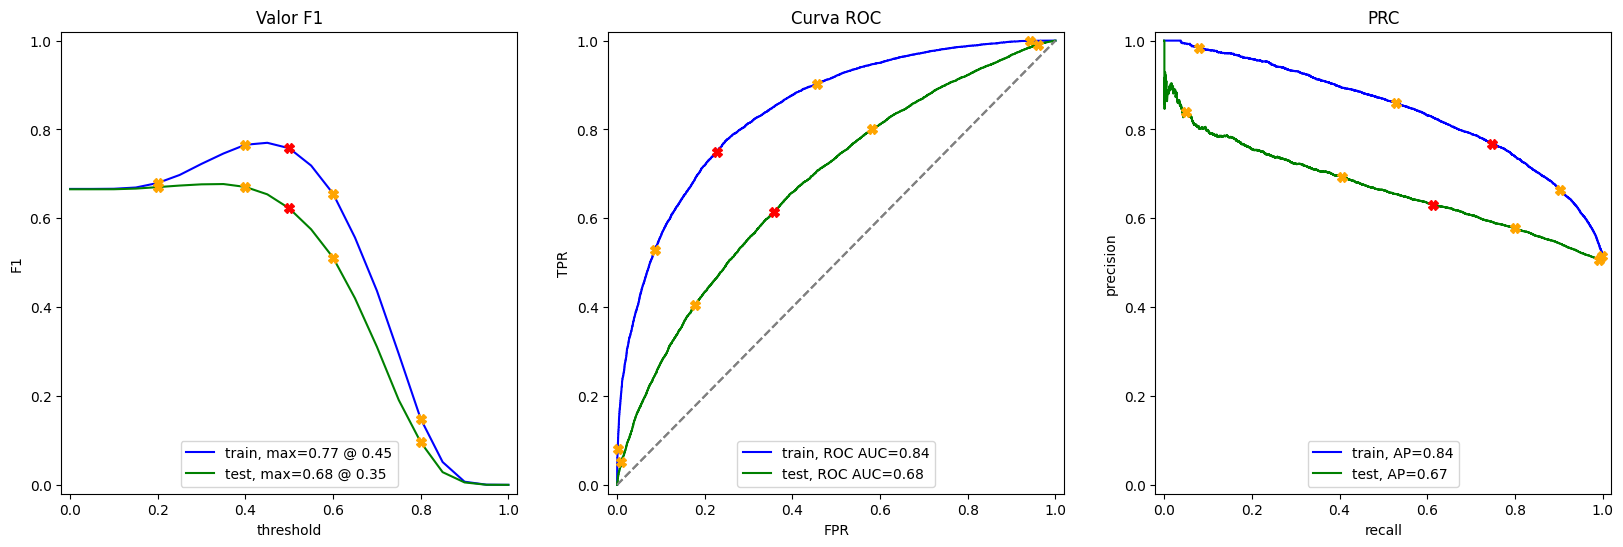

In [ ]:
model_lgb=LGBMClassifier(random_state=seed)
model_lgb.fit(features_train_lgb,target_train)
evaluate_model(model_lgb, features_train_lgb, target_train, features_test_lgb, target_test)

## Modelo 3 - NLTK, TF-IDF y LR

### Logistic Regression

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


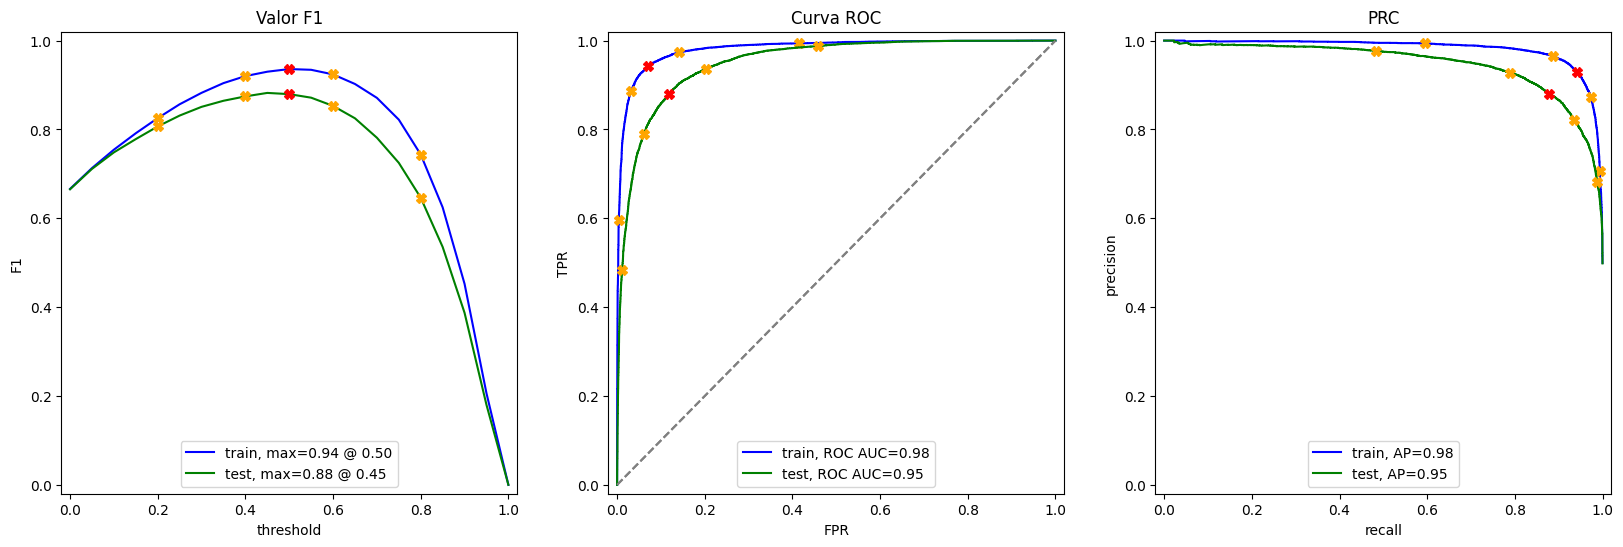

In [ ]:
model_lr=LogisticRegression()
model_lr.fit(features_train,target_train)
evaluate_model(model_lr, features_train, target_train, features_test, target_test)

# Modelo BERT

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length= max_length)
        
        padded =   np.array(ids + [0]*(max_length-len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)    
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
features_new=data['review_norm'].apply(clear_text).sample(200,random_state=seed)
target_new=data.loc[features_new.index,'pos']

In [ ]:
features_new = features_new.reset_index(drop=True)
target_new = target_new.reset_index(drop=True)

In [ ]:
features_bert = BERT_text_to_embeddings(features_new)

Uso del dispositivo cpu.


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Santiago\AppData\Local\Temp\ipykernel_14956\793361238.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
100%|██████████| 2/2 [02:49<00:00, 84.54s/it]


In [ ]:
features_train_bert,features_test_bert,target_train_bert,target_test_bert=train_test_split(features_bert,target_new,test_size=0.5,random_state=12345)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_bert.npz', train_features_bert=features_train_bert, test_features_bert=features_test_bert)

# y cargar...
with np.load('features_bert.npz') as data:
     train_features_bert = features_train_bert
     test_features_bert = features_test_bert

### Modelo Light_gbm

[LightGBM] [Info] Number of positive: 48, number of negative: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26880
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.480000 -> initscore=-0.080043
[LightGBM] [Info] Start training from score -0.080043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

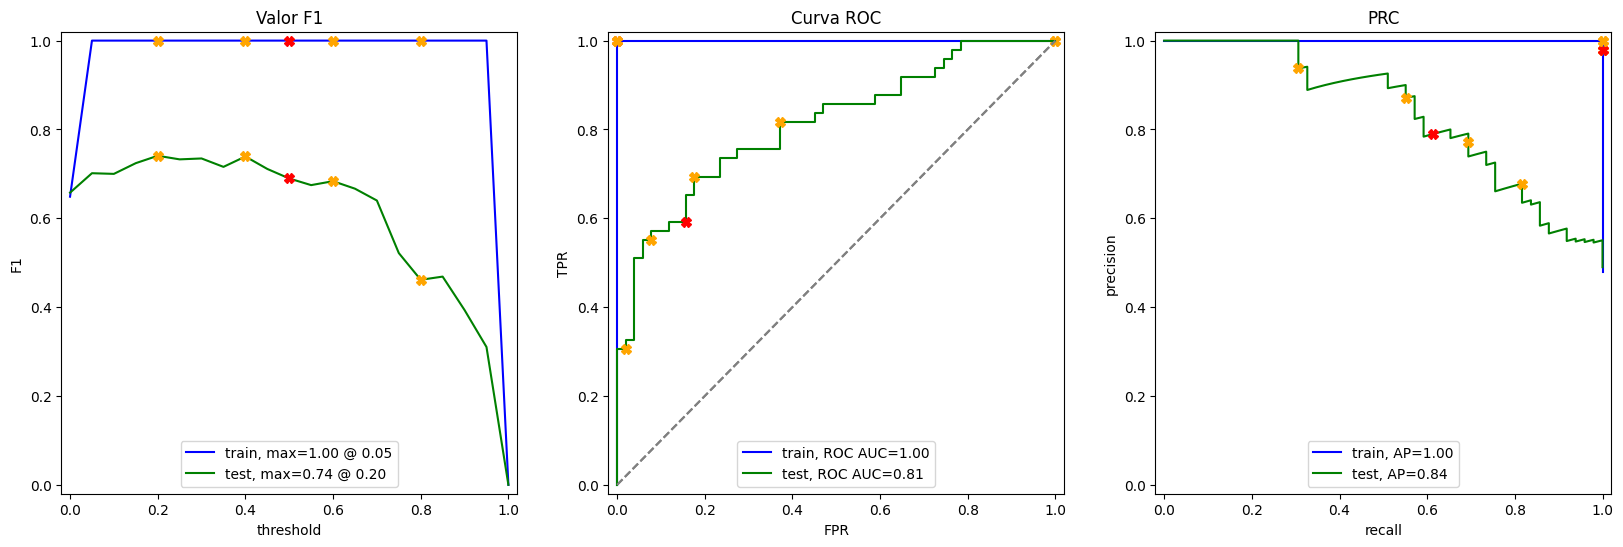

In [ ]:
model_lgb_bert=LGBMClassifier(random_state=seed)
model_lgb_bert.fit(features_train_bert,target_train_bert)
evaluate_model(model_lgb_bert, features_train_bert, target_train_bert, features_test_bert, target_test_bert)

# Mis reseñas

In [ ]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


In [ ]:
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

### NLTK and TF-IDF

In [ ]:
my_reviews_nltk=my_reviews['review_norm'].apply(nltk_tokenizer)
my_reviews_td=count_vect.transform(my_reviews_nltk)

### Modelo 1

In [ ]:
my_reviews_pred_prob = model_cat.predict_proba(my_reviews_td)[:, 1]

for i, review in enumerate(my_reviews_nltk.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it not my kind of movie
0.52:  well i wa bored and felt asleep in the middle of the movie
0.53:  i wa really fascinated with the movie
0.52:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.65:  i did n't expect the reboot to be so good writer really cared about the source material
0.63:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.31:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.66:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Modelo 2

In [ ]:
my_reviews_td_lgb = count_vect_lgb.transform(my_reviews['review_norm'])

In [ ]:
my_reviews_pred_prob = model_lgb.predict_proba(my_reviews_td_lgb)[:, 1]
tfidf_vectorizer_lgb = my_reviews_td_lgb
for i, review in enumerate(my_reviews_nltk.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.67:  i did not simply like it not my kind of movie
0.60:  well i wa bored and felt asleep in the middle of the movie
0.60:  i wa really fascinated with the movie
0.46:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.25:  i did n't expect the reboot to be so good writer really cared about the source material
0.70:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.82:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.83:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Modelo 3

In [ ]:
my_reviews_pred_prob = model_lr.predict_proba(my_reviews_td)[:, 1]
tfidf_vectorizer = my_reviews_td
for i, review in enumerate(my_reviews_nltk.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.13:  well i wa bored and felt asleep in the middle of the movie
0.46:  i wa really fascinated with the movie
0.13:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.29:  i did n't expect the reboot to be so good writer really cared about the source material
0.53:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


## Modelo BERT

In [ ]:
my_reviews_bert = BERT_text_to_embeddings(my_reviews['review_norm'])

Uso del dispositivo cpu.


100%|██████████| 1/1 [00:09<00:00,  9.80s/it]


In [ ]:
my_reviews_pred_prob = model_lgb_bert.predict_proba(my_reviews_bert)[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.64:  i did not simply like it not my kind of movie
0.46:  well i was bored and felt asleep in the middle of the movie
0.15:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn't expect the reboot to be so good writers really cared about the source material
0.45:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


# Conclusiones

1. Se pudo evidenciar en el EDA que a medida que pasa el tiempo, la cantidad de reseñas y de peliculas aumenta, adicionalmente, podemos ver que las peliculas suelen tener 1 reseña con más frecuencia y a medida que aumenta el número de reseñas la frecuencia disminuye.

2. Los generos con mejor calificación son 'Documentales, musica, musical', seguido de 'Documentales, historia, guerra' y 'Horror, musica, corto'. Por otro lado, los generos que tienen más votos son 'Aventura, Drama, Guerra', 'Drama, misterio, guerra' y 'Acción, misterio, terror'.

3. El modelo que mejor f1 score tuvo fue la regresion logística con NLTK con 0.88 de puntaje, seguido por CatBoost con NLTK con 0.85 y por último Light_gbm con SpaCy con 0.62. Al ser la cantidad mínima 0.85, podemos decir que nuestros dos primeros modelos pasan la prueba destacando la regresión logística. Podemos decir que al utilizar Spacy para este modelo en particular NLTK supera a los modelos con Spacy tanto en desempeño como en exigencia computacional, debido a que demoró 6 horas corriendo, adicionalmente, nuestro modelo Dummie fue superior al Light_gbm con Spacy con un f1 score de 0.67. 

4. El modelo BERT fue probado y a pesar de que se segmentaron los datos a 200 por la exigencia computacional que este modelo necesita, se obtuvo un f1 score de 0.69 con el modelo de clasificación Light_gbm.

5. Al probar con nuestras reseñas los distintos modelos con nuestras reseñas, al calcular la probabilidad de cada reseña, podemos ver que os resultados son similares a los de nuestros datos de prueba. El que mejor califica las reseñas es el modelo 3 de regresión logística con NLTK, seguido de CatBoost con NLTK y Light_gbm con SpaCy. Si incluimos el modelo bert este tuvo el resultado más bajo, debido a que no se entrenó con la totalidad de los datos por la exigencia computacional.
